In [85]:
import pandas as pd
import boto3
import sagemaker
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [86]:
# session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# create an S3 bucket
bucket = sagemaker_session.default_bucket()
print(bucket)

data_dir = 'capstone_data'

prefix = 'capstone_project'

sagemaker-us-east-1-077458658795


In [87]:
# load data

# already ran
# upload all data to S3
input_data = sagemaker_session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix)

In [88]:
# create model
input_size=16
batch_size =32
train_file = 'train_lstm.csv'
# train_file = 'train_lstm_sample.csv'
from sagemaker.pytorch import PyTorch
model = PyTorch(entry_point='train.py',
                source_dir='lstm',
                role=role,
                train_instance_count=1, 
                train_instance_type='ml.c4.xlarge',
                sagemaker_session=sagemaker_session,
                framework_version='1.8.1',
                py_version='py3',
                hyperparameters={
                                 'train-file': train_file,
                                 'sequence-size': 16,
                                 'input-size': input_size,
                                 'hidden-dim': 32,
                                 'learning-rate': 0.001,
                                 'batch-size': batch_size,
                                 'epochs':200
                                }
               )

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [89]:
%%time

# Train your estimator on S3 training data
model.fit({'train': f's3://{bucket}/{prefix}'})

2021-07-25 22:23:31 Starting - Starting the training job..

KeyboardInterrupt: 

In [91]:
print(model.model_data)
# s3://sagemaker-us-east-1-077458658795/pytorch-training-2021-07-25-04-55-04-095/output/model.tar.gz

KeyError: 'ModelArtifacts'

In [93]:
# model_data = model.model_data
model_data = 's3://sagemaker-us-east-1-077458658795/pytorch-training-2021-07-25-22-18-37-278/output/model.tar.gz'

In [97]:
%%time

# uncomment, if needed
#model_data, role, entry_point, framework_version=None, py_version=None
from sagemaker.pytorch import PyTorchModel
deploy_info = PyTorchModel(entry_point='predict.py',
                           source_dir='lstm',
                model_data=model_data,
                role=role,
                framework_version='1.8.1',
                py_version='py3'
               )


CPU times: user 40 µs, sys: 2 µs, total: 42 µs
Wall time: 46.5 µs


In [98]:
# test model
import numpy as np
import os
# read in test data, assuming it is stored locally
test_lstm_raw = pd.read_csv(os.path.join(data_dir, "test_lstm.csv"), header=None, names=None)
test_lstm = test_lstm_raw


# test_lstm = pd.read_csv(os.path.join(data_dir, "train_lstm_sample.csv"), header=None, names=None)
# labels are in the first column
test_y = test_lstm.iloc[:,0]
test_x = np.reshape(test_lstm.drop([0], axis=1).iloc[:,:input_size].values, (-1, input_size))
print('y')
print(test_y)
print(test_x.shape)

y
0      0.0977
1      0.0915
2      0.0922
3      0.0922
4      0.0952
        ...  
498    0.1267
499    0.1265
500    0.1343
501    0.1482
502    0.1378
Name: 0, Length: 503, dtype: float64
(503, 16)


In [99]:
# deploy your model to create a predictor
predictor = deploy_info.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

----------------------!

In [100]:
# import torch
import numpy as np
# construct input to model
test_y_preds = []
for i in range(0, test_y.size-15):
    model_in = np.reshape(test_x[i:i+16], (1, 16, input_size))
    if i <= 2:
        print(model_in)
    print(predictor.predict(model_in))
    test_y_preds.append(predictor.predict(model_in))

preds = np.reshape(np.array(test_y_preds), (1, -1))
    
print(preds[0][:100])
print(len(preds[0]))

[[[0.1104 0.1018 0.1047 0.1025 0.099  0.0962 0.0972 0.1003 0.0953 0.0942
   0.1049 0.1018 0.0992 0.0934 0.0958 0.1016]
  [0.0977 0.1104 0.1018 0.1047 0.1025 0.099  0.0962 0.0972 0.1003 0.0953
   0.0942 0.1049 0.1018 0.0992 0.0934 0.0958]
  [0.0915 0.0977 0.1104 0.1018 0.1047 0.1025 0.099  0.0962 0.0972 0.1003
   0.0953 0.0942 0.1049 0.1018 0.0992 0.0934]
  [0.0922 0.0915 0.0977 0.1104 0.1018 0.1047 0.1025 0.099  0.0962 0.0972
   0.1003 0.0953 0.0942 0.1049 0.1018 0.0992]
  [0.0922 0.0922 0.0915 0.0977 0.1104 0.1018 0.1047 0.1025 0.099  0.0962
   0.0972 0.1003 0.0953 0.0942 0.1049 0.1018]
  [0.0952 0.0922 0.0922 0.0915 0.0977 0.1104 0.1018 0.1047 0.1025 0.099
   0.0962 0.0972 0.1003 0.0953 0.0942 0.1049]
  [0.1008 0.0952 0.0922 0.0922 0.0915 0.0977 0.1104 0.1018 0.1047 0.1025
   0.099  0.0962 0.0972 0.1003 0.0953 0.0942]
  [0.0982 0.1008 0.0952 0.0922 0.0922 0.0915 0.0977 0.1104 0.1018 0.1047
   0.1025 0.099  0.0962 0.0972 0.1003 0.0953]
  [0.0988 0.0982 0.1008 0.0952 0.0922 0.0922 0.09

[[0.121661]]
[[0.11976337]]
[[0.1176063]]
[[0.11564931]]
[[0.11460031]]
[[0.11237306]]
[[0.13089344]]
[[0.13877729]]
[[0.14652261]]
[[0.15007818]]
[[0.20207062]]
[[0.22977382]]
[[0.20367944]]
[[0.19191962]]
[[0.16614258]]
[[0.16607136]]
[[0.18626723]]
[[0.18186763]]
[[0.18424433]]
[[0.196502]]
[[0.22766292]]
[[0.2195862]]
[[0.21981019]]
[[0.22060016]]
[[0.2114031]]
[[0.20521691]]
[[0.18512273]]
[[0.17781433]]
[[0.18614668]]
[[0.18530118]]
[[0.1633915]]
[[0.16615582]]
[[0.16614273]]
[[0.18224776]]
[[0.18232605]]
[[0.19226667]]
[[0.18562526]]
[[0.17026308]]
[[0.18417051]]
[[0.20272884]]
[[0.19056654]]
[[0.19924444]]
[[0.17821014]]
[[0.1734924]]
[[0.17077923]]
[[0.16915634]]
[[0.1631679]]
[[0.15406346]]
[[0.1868988]]
[[0.19488558]]
[[0.20978695]]
[[0.20877767]]
[[0.19735295]]
[[0.19699022]]
[[0.19281507]]
[[0.19644377]]
[[0.22006074]]
[[0.23246437]]
[[0.23395231]]
[[0.25461096]]
[[0.26888976]]
[[0.31636146]]
[[0.27971742]]
[[0.26469645]]
[[0.2684461]]
[[0.2509787]]
[[0.2159119]]
[[0.22580

In [102]:
test_x_3 = np.reshape(test_x[0:16], (1, 16, input_size))
print(test_y.size)
for i in range(1, test_y.size-15):
    test_x_3 = np.concatenate((test_x_3, np.reshape(test_x[i:i+16], (1, 16, input_size))), axis=0)
print(test_x_3)
print(predictor.predict(model_in))

503
[[[0.1104 0.1018 0.1047 ... 0.0934 0.0958 0.1016]
  [0.0977 0.1104 0.1018 ... 0.0992 0.0934 0.0958]
  [0.0915 0.0977 0.1104 ... 0.1018 0.0992 0.0934]
  ...
  [0.1127 0.1222 0.1191 ... 0.1104 0.1018 0.1047]
  [0.1103 0.1127 0.1222 ... 0.0977 0.1104 0.1018]
  [0.111  0.1103 0.1127 ... 0.0915 0.0977 0.1104]]

 [[0.0977 0.1104 0.1018 ... 0.0992 0.0934 0.0958]
  [0.0915 0.0977 0.1104 ... 0.1018 0.0992 0.0934]
  [0.0922 0.0915 0.0977 ... 0.1049 0.1018 0.0992]
  ...
  [0.1103 0.1127 0.1222 ... 0.0977 0.1104 0.1018]
  [0.111  0.1103 0.1127 ... 0.0915 0.0977 0.1104]
  [0.1147 0.111  0.1103 ... 0.0922 0.0915 0.0977]]

 [[0.0915 0.0977 0.1104 ... 0.1018 0.0992 0.0934]
  [0.0922 0.0915 0.0977 ... 0.1049 0.1018 0.0992]
  [0.0922 0.0922 0.0915 ... 0.0942 0.1049 0.1018]
  ...
  [0.111  0.1103 0.1127 ... 0.0915 0.0977 0.1104]
  [0.1147 0.111  0.1103 ... 0.0922 0.0915 0.0977]
  [0.1158 0.1147 0.111  ... 0.0922 0.0922 0.0915]]

 ...

 [[0.148  0.1596 0.1491 ... 0.1305 0.13   0.1268]
  [0.1452 0.148 

In [110]:
rmse = mean_squared_error( test_lstm[0][-len(preds[0]):], pd.Series(preds[0]), squared=True)
print(rmse)

0.00043508187743072365


In [122]:
# transform back:
y_orig = 100 * test_lstm[0][-len(preds[0]):].reset_index(drop=True)
y_pred = pd.Series(100 * preds[0])

In [125]:
rmse = mean_squared_error(y_orig, y_pred, squared=False)
print(rmse)

2.0858616472201166


Text(0.5, 1.0, 'LSTM - Predicted vs Actual VIX Prices During Test Period')

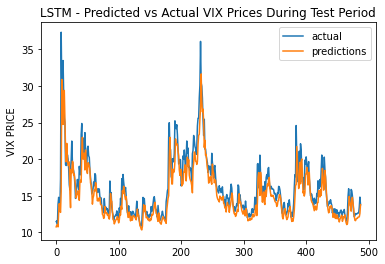

In [124]:
y_orig.plot(label="actual")
y_pred.plot(label="predictions")
plt.legend(loc="upper right")
plt.ylabel('VIX PRICE')
plt.title('LSTM - Predicted vs Actual VIX Prices During Test Period')

In [107]:
# predictor.delete_endpoint()